In [3]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, accuracy_score

from proj2.config import HEART_DATA_FILE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Add, Activation
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### Data Import

In [4]:

import pandas as pd

df = pd.read_csv(HEART_DATA_FILE)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Q1 - Data Exploration

#### Feature Overview

In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Check Missing Values & Data Types

In [6]:
# Check for missing values
print(df.isnull().sum())

# Data types
print(df.dtypes)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


#### Class Distribution

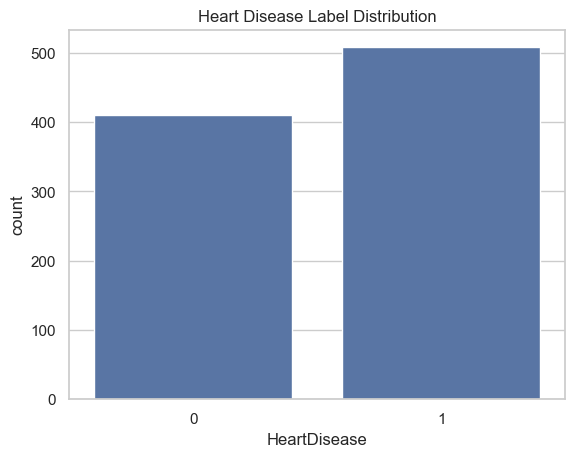

HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64

In [20]:
sns.countplot(data=df, x='HeartDisease')
plt.title("Heart Disease Label Distribution")
plt.show()

# Percent breakdown
df['HeartDisease'].value_counts(normalize=True) * 100

#### Distribution of Numerical Features

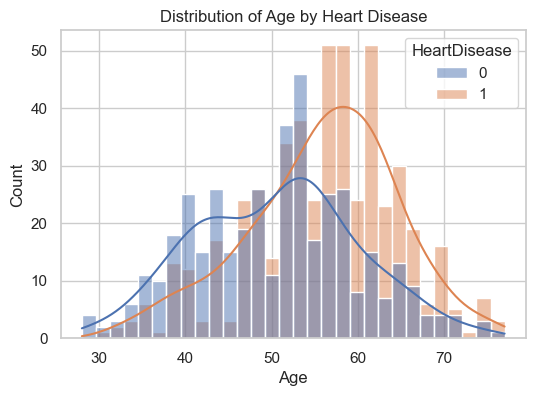

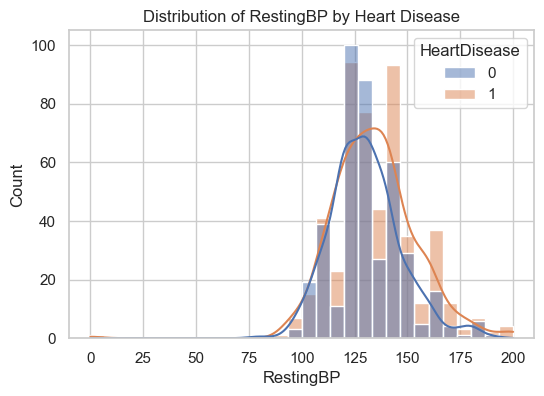

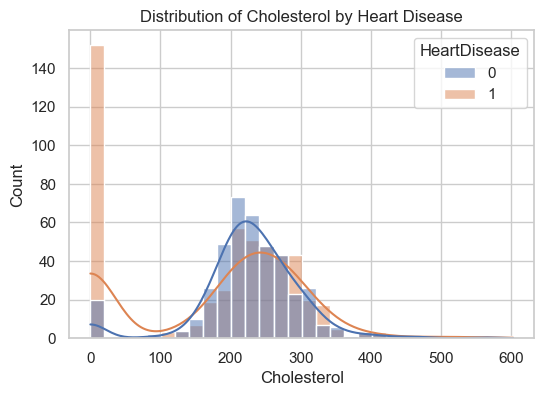

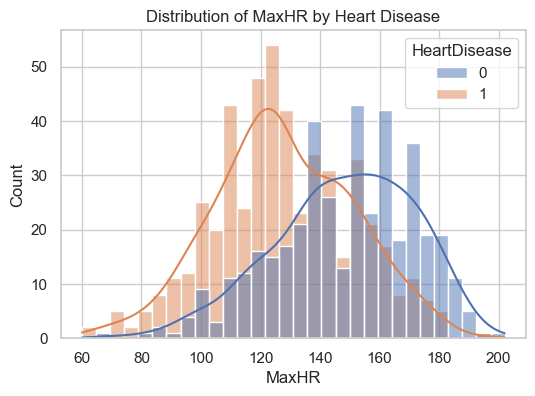

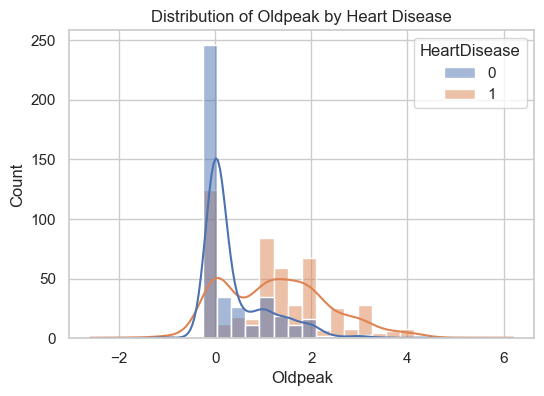

In [23]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df, x=col, hue="HeartDisease", kde=True, bins=30)
    plt.title(f'Distribution of {col} by Heart Disease')
    plt.show()

#### Outliers

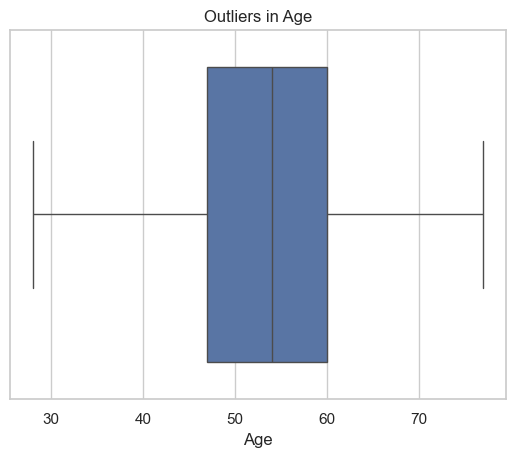

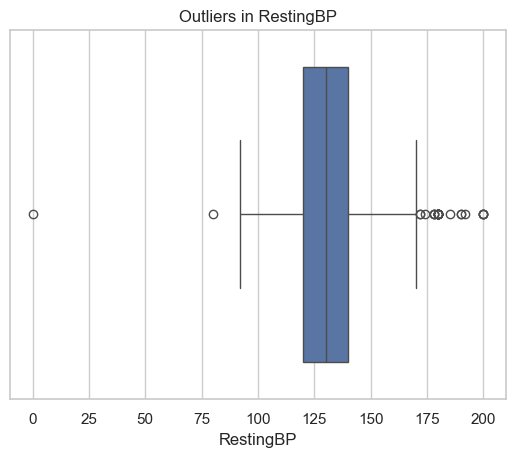

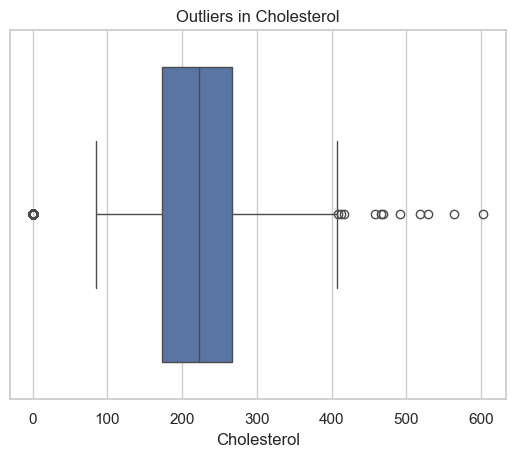

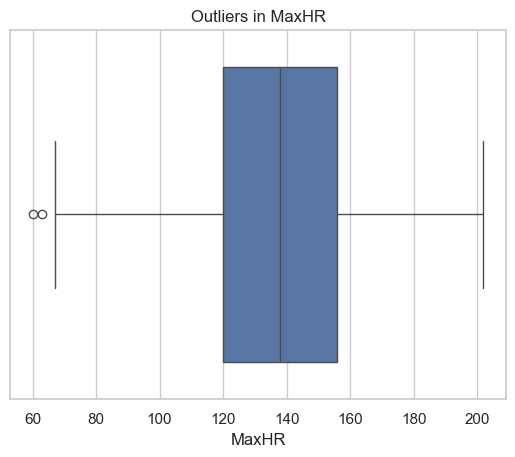

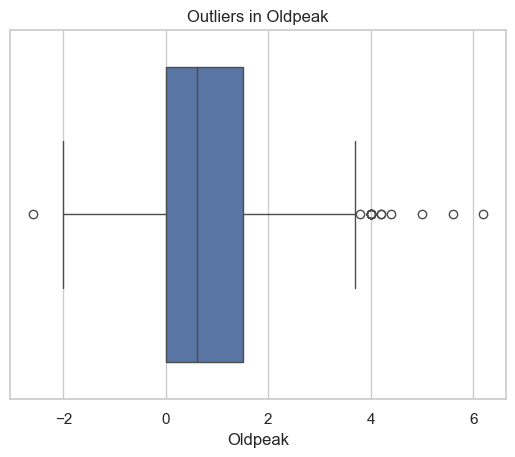

In [26]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()


In [42]:
print(f"Unrealistic Cholesterol values: {len(df[df['Cholesterol'] > 400])}")


Unrealistic Cholesterol values: 13


In [41]:
print(f"Unrealistic Oldpeak values: {len(df[df['Oldpeak'] < 0])}")

Unrealistic Oldpeak values: 13


#### Categorical Feature Counts

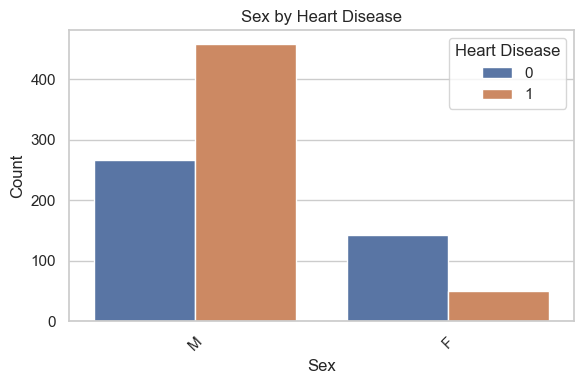

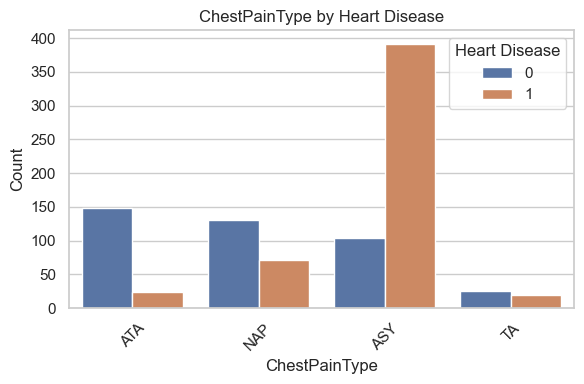

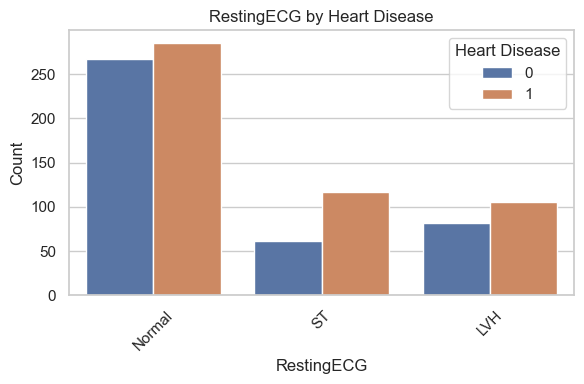

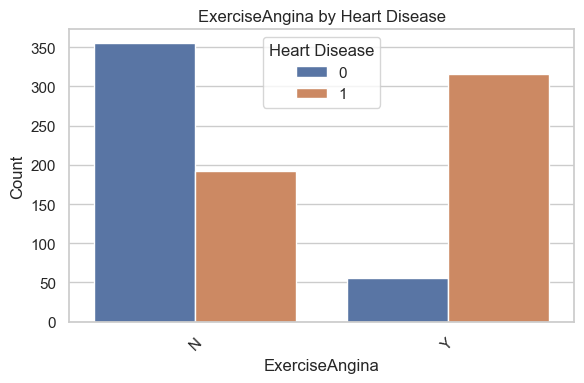

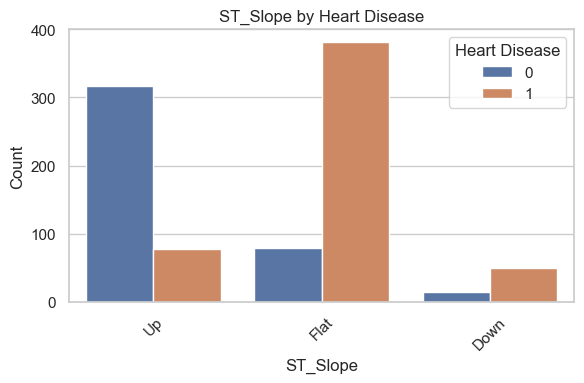

In [25]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue='HeartDisease')
    plt.title(f"{col} by Heart Disease")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Heart Disease")
    plt.tight_layout()
    plt.show()

## Q1.3 - Data Preprocessing

In [7]:
# Encode categorical variables
ordinal_binary_cols = ['Sex', 'ExerciseAngina', 'ST_Slope']
one_hot_cols = ['ChestPainType', 'RestingECG']
df_encoded = df.copy()

le = LabelEncoder()
for col in ordinal_binary_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

# Check the encoding
df_encoded.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,2,0,True,False,False,True,False
1,49,0,160,180,0,156,0,1.0,1,1,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,2,0,True,False,False,False,True
3,48,0,138,214,0,108,1,1.5,1,1,False,False,False,True,False
4,54,1,150,195,0,122,0,0.0,2,0,False,True,False,True,False


#### Impute Nonsensical Values

In [8]:
df_imputation = df_encoded.copy()
df_imputation['Cholesterol'] = df_imputation['Cholesterol'].replace(0, np.nan)
df_imputation['RestingBP'] = df_imputation['RestingBP'].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=5)
df_imputation_array = imputer.fit_transform(df_imputation)
df_imputation = pd.DataFrame(df_imputation_array, columns=df_imputation.columns)


Any remaining NaNs in Cholesterol? 0


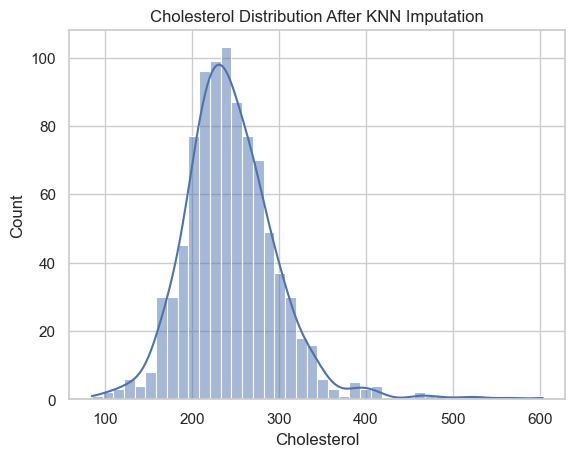

In [9]:
print("Any remaining NaNs in Cholesterol?", df_imputation['Cholesterol'].isna().sum())
sns.histplot(df_imputation['Cholesterol'], kde=True)
plt.title("Cholesterol Distribution After KNN Imputation")
plt.show()


#### Outlier handeling

In [10]:
q99 = df_imputation['Cholesterol'].quantile(0.99)
df_imputation['Cholesterol'] = np.where(df_imputation['Cholesterol'] > q99, q99, df_imputation['Cholesterol'])

In [11]:
df_imputation['Oldpeak'] = df_imputation['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

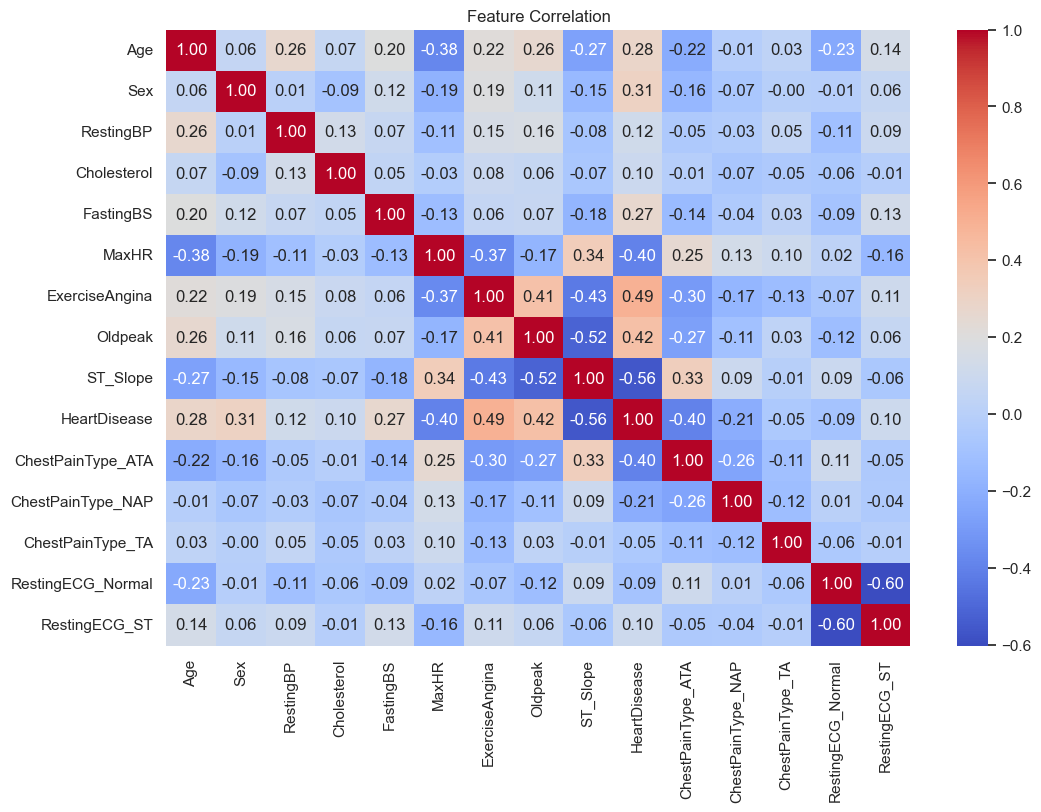

In [12]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_imputation.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation")
plt.show()

In [13]:
# Feature scaling
features = df_imputation.drop("HeartDisease", axis=1)
target = df_imputation["HeartDisease"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)
X = df_imputation.drop("HeartDisease", axis=1)

---

# Q2 - Logistic Lasso Regression
#### Fit Lasso Logistic Model

In [14]:
# L1-regularized logistic regression (Lasso)
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

## Q2.2 TO CHECK
The preprocessing steps which are crucial are the imputing, since otherwise we can not feed the model with data, outlier handling, since otherwise the generalization is less stable, and finally the standardization, since the magnitude might make the model less precise.

---

## Q2.3

#### Performance 

In [15]:
y_pred = lasso_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


F1 Score: 0.886
Balanced Accuracy: 0.864

Classification Report:

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85        82
         1.0       0.86      0.91      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



---
## Q2.4

#### Visualization of Feature Importance

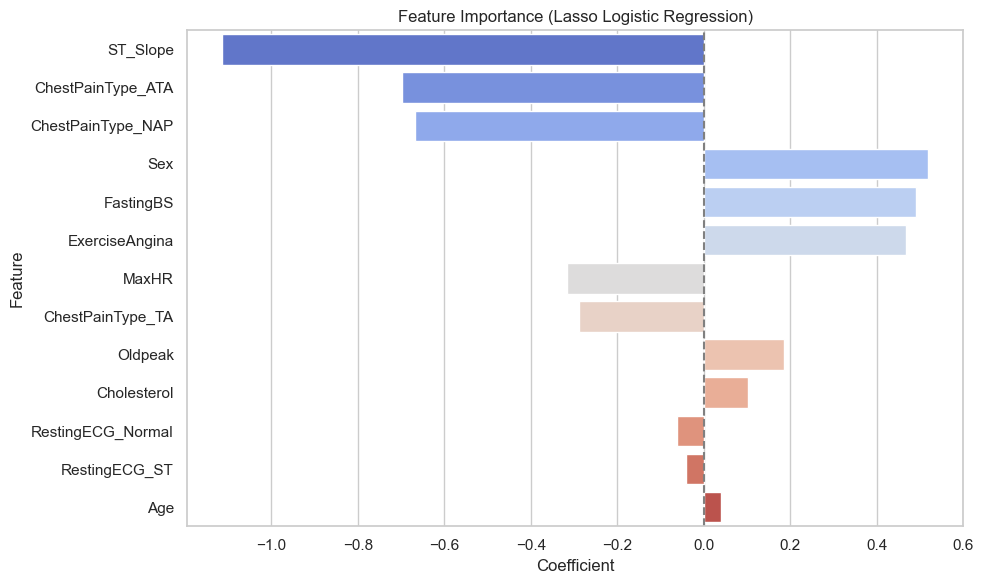

In [16]:
# Get feature names and corresponding coefficients
feature_names = X.columns
coefficients = lasso_model.coef_[0]

# Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# Sort by absolute importance
coef_df = coef_df.sort_values(by="Coefficient", key=lambda x: np.abs(x), ascending=False)

# Filter non-zero coefficients (Lasso sets some to 0)
non_zero = coef_df[coef_df['Coefficient'] != 0]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=non_zero, x='Coefficient', y='Feature', palette='coolwarm')
plt.title("Feature Importance (Lasso Logistic Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

---

## Q2.5 TO CHECK
Using Lasso logistic regression for feature selection followed by fitting a standard logistic regression on the selected variables can improve interpretability and model simplicity, as Lasso effectively identifies a sparse subset of potentially important predictors. However, this approach has critical limitations: it introduces selection bias by using the same data for both feature selection and model refitting, which can lead to overconfident and misleading coefficient estimates. Additionally, Lasso may arbitrarily select among correlated features, distorting the interpretation of their true influence. Since standard logistic regression assumes that the model structure is fixed a priori, any statistical inference (e.g., coefficient significance) made after Lasso-based selection is not valid unless adjusted for. Therefore, while this method is practical for narrowing down variables, one should be cautious about drawing strong conclusions regarding feature importance without applying proper post-selection inference techniques.

---
# Q3 - Multi-Layer Perceptrons
### Q3.1 - MLP Training

In [17]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=0)


#### Evaluation

In [18]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
F1 Score: 0.8712871287128713
Accuracy: 0.8586956521739131
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84        82
         1.0       0.88      0.86      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



---
### Q3.2 - SHAP Explanations

In [19]:
import shap
shap.initjs()

In [ ]:
from IPython.display import display
# 1) wrap model.predict so it returns a flat array of probabilities
predict_proba_fn = lambda X: model.predict(X).ravel()

# 2) re‑create the explainer on the positive‐class probability
explainer = shap.KernelExplainer(
    predict_proba_fn,      # now a function returning P(y=1)
    X_train[:100],         # background data
    link="logit"           # to get log‐odds explanations
)

# 3) pick your 4 samples (2 positive, 2 negative)
pos_idx = np.where(y_test.values == 1)[0][:2]
neg_idx = np.where(y_test.values == 0)[0][:2]
sample_indices = np.concatenate([pos_idx, neg_idx])
X_sample = X_test[sample_indices]

# 4) compute SHAP values
shap_values = explainer.shap_values(X_sample)

# KernelExplainer for a single‐output model returns a list of length 1
# unpack it so shap_vals is an (n_samples, n_features) array
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
    base_val = explainer.expected_value[0]
else:
    shap_vals = shap_values
    base_val = explainer.expected_value

# 5) plot force plots for all samples at once
# Loop through each sample and display individual force plots
pd_sample = pd.DataFrame(X_sample, columns=X.columns)
for i in range(X_sample.shape[0]):
    display(shap.force_plot(
        base_val,
        shap_vals[i],
        pd_sample.iloc[i],   # use .iloc to pass a Series, not an ndarray
        feature_names=X.columns
    ))
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 1s 185us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 1s 191us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 1s 174us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 1s 176us/step


The SHAP force plots for the four selected samples show varying feature contributions depending on the prediction. For the two positive predictions (with high output log-odds of ~3.24 and 1.03), key contributing features include ST_Slope, ExerciseAngina, and FastingBS, which pushed the model strongly toward predicting the presence of heart disease. In contrast, the two negative predictions (with log-odds ~–1.71 and –3.55) were heavily influenced by features such as ChestPainType_ATA, Sex, and MaxHR, which decreased the likelihood of a positive outcome. Notably, ChestPainType_ATA consistently acted as a strong negative contributor, while ST_Slope and ExerciseAngina were the most impactful positive contributors across samples. This highlights that while some features are consistently important, their effects can vary in direction and magnitude depending on the patient profile.

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 536us/step


  1%|          | 1/100 [00:05<08:30,  5.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 508us/step


  2%|▏         | 2/100 [00:10<08:58,  5.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 797us/step


  3%|▎         | 3/100 [00:19<11:02,  6.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  4%|▍         | 4/100 [00:30<13:50,  8.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  5%|▌         | 5/100 [00:41<14:50,  9.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  6%|▌         | 6/100 [00:51<15:15,  9.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


  7%|▋         | 7/100 [01:03<15:59, 10.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  8%|▊         | 8/100 [01:14<16:02, 10.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  9%|▉         | 9/100 [01:24<15:59, 10.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 10%|█         | 10/100 [01:35<16:02, 10.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 11%|█         | 11/100 [01:47<16:14, 10.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 954us/step


 12%|█▏        | 12/100 [01:56<15:08, 10.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 825us/step


 13%|█▎        | 13/100 [02:04<13:54,  9.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 807us/step


 14%|█▍        | 14/100 [02:11<12:37,  8.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 486us/step


 15%|█▌        | 15/100 [02:15<10:36,  7.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 524us/step


 16%|█▌        | 16/100 [02:20<09:21,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 513us/step


 17%|█▋        | 17/100 [02:25<08:37,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 515us/step


 18%|█▊        | 18/100 [02:30<08:02,  5.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 500us/step


 19%|█▉        | 19/100 [02:35<07:27,  5.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 532us/step


 20%|██        | 20/100 [02:40<07:07,  5.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 512us/step


 21%|██        | 21/100 [02:45<06:50,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 492us/step


 22%|██▏       | 22/100 [02:49<06:29,  4.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 536us/step


 23%|██▎       | 23/100 [02:54<06:19,  4.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step


 24%|██▍       | 24/100 [02:59<06:22,  5.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 535us/step


 25%|██▌       | 25/100 [03:04<06:16,  5.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 498us/step


 26%|██▌       | 26/100 [03:09<06:02,  4.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 516us/step


 27%|██▋       | 27/100 [03:14<05:54,  4.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 511us/step


 28%|██▊       | 28/100 [03:18<05:46,  4.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 932us/step


 29%|██▉       | 29/100 [03:26<06:39,  5.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 525us/step


 30%|███       | 30/100 [03:31<06:20,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 520us/step


 31%|███       | 31/100 [03:36<06:05,  5.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 522us/step


 32%|███▏      | 32/100 [03:41<05:52,  5.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 587us/step


 33%|███▎      | 33/100 [03:46<05:56,  5.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 630us/step


 34%|███▍      | 34/100 [03:52<05:58,  5.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 779us/step


 35%|███▌      | 35/100 [04:00<06:37,  6.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 608us/step


 36%|███▌      | 36/100 [04:05<06:15,  5.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 520us/step


 37%|███▋      | 37/100 [04:10<05:52,  5.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 551us/step


 38%|███▊      | 38/100 [04:16<05:57,  5.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 599us/step


 39%|███▉      | 39/100 [04:22<05:53,  5.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 3s 487us/step


 40%|████      | 40/100 [04:27<05:25,  5.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 571us/step


 41%|████      | 41/100 [04:32<05:13,  5.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 592us/step


 42%|████▏     | 42/100 [04:38<05:25,  5.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 43%|████▎     | 43/100 [04:48<06:32,  6.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 801us/step


 44%|████▍     | 44/100 [04:56<06:38,  7.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 918us/step


 45%|████▌     | 45/100 [05:05<07:14,  7.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 740us/step


 46%|████▌     | 46/100 [05:13<07:02,  7.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 990us/step


 47%|████▋     | 47/100 [05:22<07:15,  8.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 48%|████▊     | 48/100 [05:32<07:35,  8.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 49%|████▉     | 49/100 [05:42<07:37,  8.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 50%|█████     | 50/100 [05:52<07:52,  9.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 51%|█████     | 51/100 [06:04<08:25, 10.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 52%|█████▏    | 52/100 [06:16<08:35, 10.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 53%|█████▎    | 53/100 [06:26<08:16, 10.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 54%|█████▍    | 54/100 [06:37<08:11, 10.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 55%|█████▌    | 55/100 [06:49<08:17, 11.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 56%|█████▌    | 56/100 [07:01<08:14, 11.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 57%|█████▋    | 57/100 [07:12<08:04, 11.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 58%|█████▊    | 58/100 [07:24<07:57, 11.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 59%|█████▉    | 59/100 [07:35<07:38, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 60%|██████    | 60/100 [07:47<07:43, 11.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 61%|██████    | 61/100 [07:58<07:21, 11.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 62%|██████▏   | 62/100 [08:10<07:15, 11.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 63%|██████▎   | 63/100 [08:21<07:08, 11.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 64%|██████▍   | 64/100 [08:33<06:59, 11.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 65%|██████▌   | 65/100 [08:45<06:49, 11.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 970us/step


 66%|██████▌   | 66/100 [08:54<06:11, 10.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 67%|██████▋   | 67/100 [09:06<06:13, 11.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


 68%|██████▊   | 68/100 [09:19<06:13, 11.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 69%|██████▉   | 69/100 [09:31<06:09, 11.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 70%|███████   | 70/100 [09:44<06:06, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 71%|███████   | 71/100 [09:56<05:52, 12.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 72%|███████▏  | 72/100 [10:09<05:42, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 5s 826us/step


 73%|███████▎  | 73/100 [10:16<04:49, 10.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step


 74%|███████▍  | 74/100 [10:22<04:02,  9.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 75%|███████▌  | 75/100 [10:32<04:00,  9.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 923us/step


 76%|███████▌  | 76/100 [10:41<03:43,  9.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 77%|███████▋  | 77/100 [10:52<03:46,  9.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 78%|███████▊  | 78/100 [11:03<03:43, 10.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 877us/step


 79%|███████▉  | 79/100 [11:11<03:22,  9.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 80%|████████  | 80/100 [11:23<03:22, 10.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 81%|████████  | 81/100 [11:34<03:17, 10.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step


 82%|████████▏ | 82/100 [11:43<02:59, 10.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 83%|████████▎ | 83/100 [11:53<02:52, 10.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 84%|████████▍ | 84/100 [12:04<02:46, 10.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 85%|████████▌ | 85/100 [12:15<02:37, 10.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 86%|████████▌ | 86/100 [12:27<02:31, 10.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 87%|████████▋ | 87/100 [12:38<02:22, 10.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 88%|████████▊ | 88/100 [12:49<02:13, 11.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 89%|████████▉ | 89/100 [13:01<02:04, 11.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 90%|█████████ | 90/100 [13:13<01:53, 11.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 91%|█████████ | 91/100 [13:24<01:42, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 92%|█████████▏| 92/100 [13:36<01:31, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 93%|█████████▎| 93/100 [13:46<01:16, 10.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 94%|█████████▍| 94/100 [13:55<01:03, 10.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 95%|█████████▌| 95/100 [14:06<00:53, 10.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 96%|█████████▌| 96/100 [14:17<00:43, 10.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 97%|█████████▋| 97/100 [14:29<00:33, 11.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 98%|█████████▊| 98/100 [14:41<00:22, 11.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 99%|█████████▉| 99/100 [14:52<00:11, 11.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6488/6488 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


100%|██████████| 100/100 [15:05<00:00,  9.05s/it]


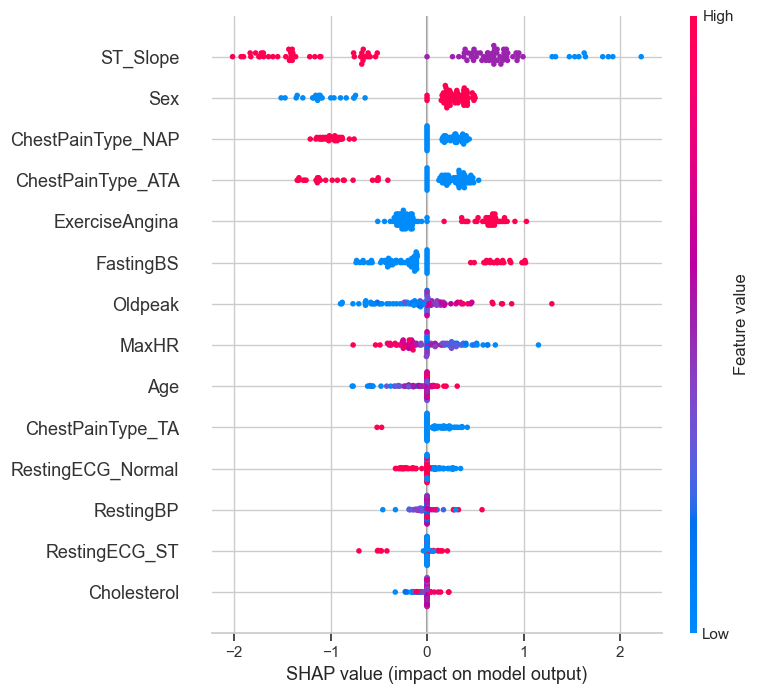

In [65]:
# Global feature importance
shap_values_global = explainer.shap_values(X_test[:100])
shap.summary_plot(shap_values_global, X_test[:100], feature_names=X.columns)


In [22]:
# Compare top features across samples
top_feats = [np.argsort(np.abs(shap_values[i]))[::-1][:3] for i in range(len(shap_values))]
for i, feats in enumerate(top_feats):
    print(f"Top features for sample {i}: {[X.columns[j] for j in feats]}")


Top features for sample 0: ['ST_Slope', 'Sex', 'ChestPainType_ATA']
Top features for sample 1: ['ChestPainType_NAP', 'ST_Slope', 'MaxHR']
Top features for sample 2: ['ChestPainType_NAP', 'Sex', 'Age']
Top features for sample 3: ['ST_Slope', 'ChestPainType_NAP', 'MaxHR']


### Explanation:
By comparing the top 3 most influential features across our 4 individual samples, we observe that certain features (e.g., chol, age, thalach) appear repeatedly, suggesting some consistency in local explanations. However, there is still variation — different samples emphasize different features depending on their individual values and interactions. When comparing these local importances to the global SHAP summary plot, we see partial overlap: features like chol and thalach may appear both globally and locally, but not always in the same order. This illustrates that while some features are consistently important, SHAP explanations adapt to individual cases, making them both locally accurate and globally interpretable.

---

# Q4 - Neural Additive Models
### Q4.1 - NAM Architecture

In [23]:
n_features = X_train.shape[1]
feature_names = X.columns.tolist()

# create one Input & subnet per feature
inputs = []
outputs = []
for i, name in enumerate(feature_names):
    inp = Input(shape=(1,), name=f"inp_{name}")
    x = Dense(32, activation='relu', name=f"dense1_{name}")(inp)
    x = Dense(16, activation='relu', name=f"dense2_{name}")(x)
    out = Dense(1, activation=None, name=f"shape_{name}")(x)
    inputs.append(inp)
    outputs.append(out)

# sum all feature sub‑net outputs + bias
combined = Add(name="sum_features")(outputs)
prob = Activation('sigmoid', name="prediction")(combined)

# assemble model
nam = Model(inputs=inputs, outputs=prob, name="NeuralAdditiveModel")
nam.compile(optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# 3) Prepare inputs as list of single‑column arrays
def to_feature_list(X_array):
    return [X_array[:, i].reshape(-1,1) for i in range(X_array.shape[1])]

X_train_list = to_feature_list(X_train)
X_test_list  = to_feature_list(X_test)

#### Training

In [24]:
history = nam.fit(
    X_train_list, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6820 - loss: 0.5494 - val_accuracy: 0.7027 - val_loss: 0.5839
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8023 - loss: 0.4285 - val_accuracy: 0.7162 - val_loss: 0.5694
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8351 - loss: 0.3587 - val_accuracy: 0.7432 - val_loss: 0.5524
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8600 - loss: 0.3319 - val_accuracy: 0.7973 - val_loss: 0.5350
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8516 - loss: 0.3246 - val_accuracy: 0.8243 - val_loss: 0.5213
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.3529 - val_accuracy: 0.8243 - val_loss: 0.5156
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8608 - loss: 0.3180 - val_accuracy: 0.8243 - val_loss: 0.5086
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8712 - loss: 0.3231 - val_accuracy: 0.8108 - val_loss

#### Evaluation

In [25]:
y_pred_proba = nam.predict(X_test_list).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Test Accuracy:          ", accuracy_score(y_test, y_pred))
print("Test F1 Score:          ", f1_score(y_test, y_pred))
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test Accuracy:           0.875
Test F1 Score:           0.8844221105527639
Test Balanced Accuracy:  0.87649450023912

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.89      0.86        82
         1.0       0.91      0.86      0.88       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



---
### Q4.2 - Visualize Feature Importance

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


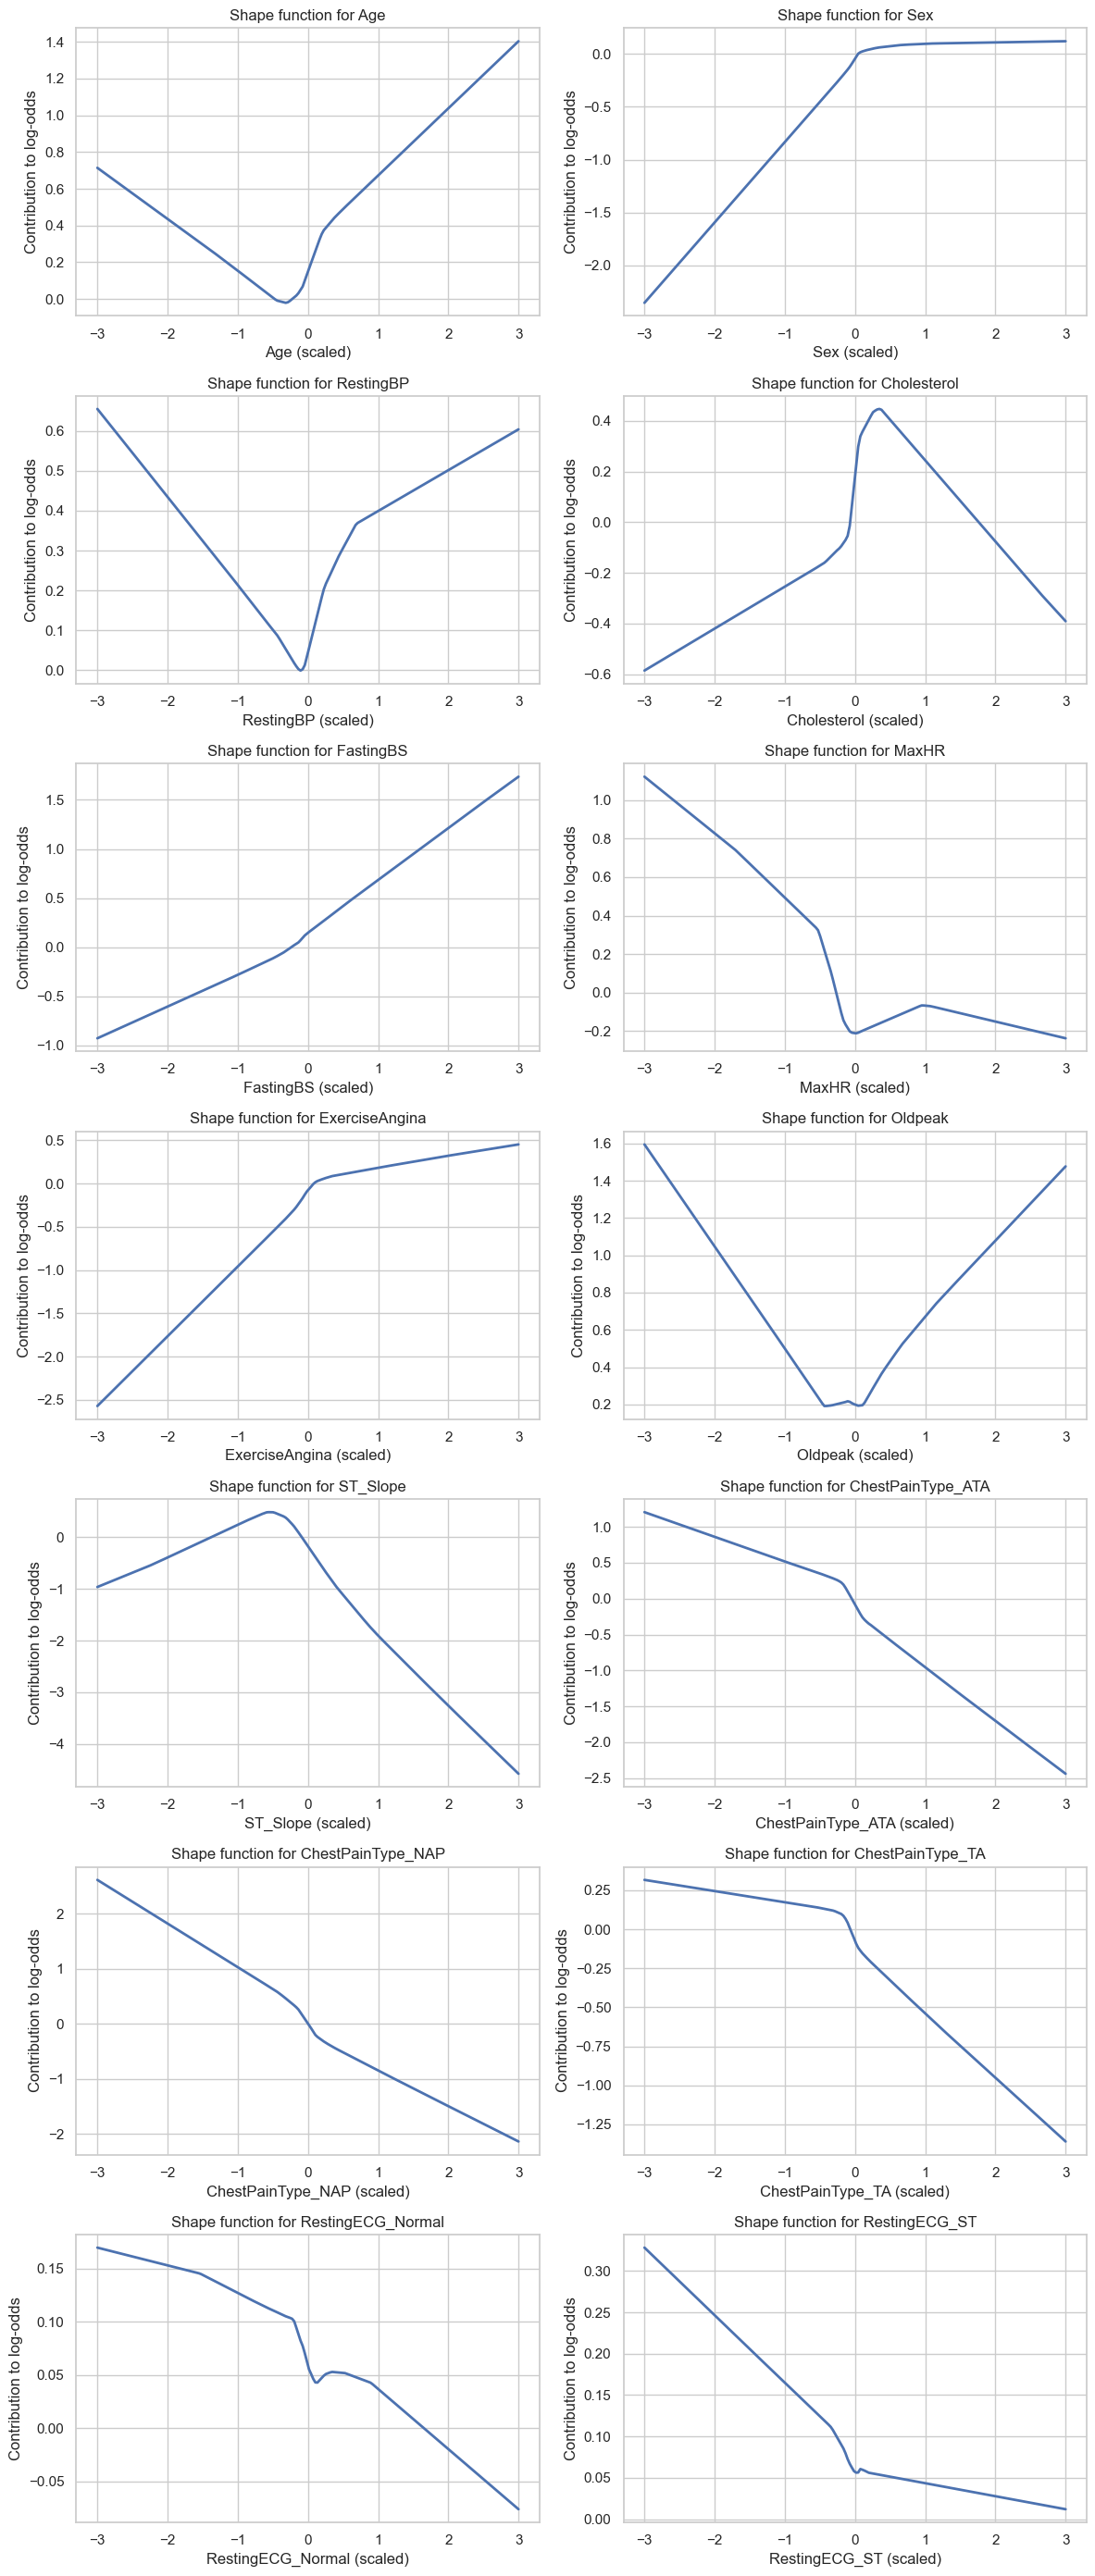

In [72]:

# For each feature, sweep its range and hold others at 0 (mean after scaling)
grid = np.linspace(-3, 3, 200)  # scaled feature range
fig, axes = plt.subplots(nrows= (n_features+1)//2, ncols=2, figsize=(12, 4* ((n_features+1)//2)))
axes = axes.flatten()

for idx, name in enumerate(feature_names):
    # build batch: for each grid point, set that feature = grid, others = 0
    X_batch = np.zeros((len(grid), n_features))
    X_batch[:, idx] = grid
    X_list = to_feature_list(X_batch)
    # get sub‑net output (before sigmoid)
    # extract the output of the “shape_{name}” layer
    shape_model = Model(inputs=nam.inputs,
                        outputs=nam.get_layer(f"shape_{name}").output)
    vals = shape_model.predict(X_list).ravel()
    # plot
    ax = axes[idx]
    ax.plot(grid, vals, lw=2)
    ax.set_title(f"Shape function for {name}")
    ax.set_xlabel(name + " (scaled)")
    ax.set_ylabel("Contribution to log-odds")
    ax.grid(True)

plt.tight_layout()
plt.show()

---
## Q4.3
The Neural Additive Model combines the interpretability of Logistic Regression with the expressive power of neural networks. Unlike Logistic Regression, NAM models each feature’s effect non-linearly using a small subnetwork, enabling it to capture richer individual feature patterns. Compared to MLPs, NAM avoids feature interactions and enforces additive structure, making it significantly more interpretable while sacrificing some predictive complexity.

---

## Q4.4
NAMs are more interpretable than MLPs because they enforce an additive structure over individual features, where each feature is passed through its own isolated subnetwork that models a univariate function. This design means the effect of each feature on the prediction can be visualized independently using a shape function, showing exactly how the feature contributes to the model’s output. In contrast, MLPs entangle all features through dense layers, making it difficult to attribute prediction behavior to specific inputs. Even though both use non-linear neural networks, NAMs retain transparency by structuring non-linearity in a feature-wise decomposable way.